# Início Colab

In [1]:
'''from google.colab import drive

drive.mount('/content/drive/')'''

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Importações

In [2]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from math import ceil

import torch
from torch import nn
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import functional as VF

# Utilidades

Função para mostrar uma imagem.
*   Recebe um tensor de imagem e a sua label correspondente
*   Mostra a imagem dada com a label de título

In [3]:
def plot_img(img, label = 'NULL', std = 1, mean = 0):
    #Caso normalize
    img = img * std + mean 
    
    _,ax1 = plt.subplots(1)
    img = VF.to_pil_image(img[0])
    show = ax1.imshow(img)
    
    ax1.set_title(label)
    
    plt.show()

Função para mostrar dois gráficos.


*   Gráfico das losses de teste e validação durante as epochs
*   Gráfico da acurácia durante as epochs



In [4]:
def plot_train_graph(list_train_loss, list_eval_loss, list_acc, epochs):
    fig, axs = plt.subplots(2, figsize=(15,8))
    axs[0].plot(range(1, epochs+1), list_train_loss,label="Train loss") #Plota o erro de treino X epocas
    axs[0].plot(range(1, epochs+1), list_eval_loss, label="Test loss") #Plota o erro de teste x epocas
    axs[0].set(xticks=range(1, epochs+1))
    axs[0].set_title('Losses x Epochs') #Define o título
    axs[0].set(xlabel='Epochs') #Define o nome do eixo x
    axs[0].set(ylabel='Losses') #Define o nome do eixo y
    axs[0].legend() #Mostra a legenda
    axs[0].grid(True) #Mostra a grade


    axs[1].plot(range(1, epochs+1), list_acc, label='Accuracy') #Plota a acuracia para erro de 1 graus x epocas
    axs[1].set(xticks=range(1, epochs+1))
    axs[1].set_title('Accuracy x epochs') #Define o título
    axs[1].set(xlabel='Epochs') #Define o nome do eixo x
    axs[1].set(ylabel='Accuracy (%)') #Define o nome do eixo y
    axs[1].legend(loc='lower right') #Mostra a legenda
    axs[1].grid(True) #Mostra a grade

    plt.tight_layout()

# Processamento dos dados

Lê os dados usando torchvision.
*   transforms faz modificações nas fotos por fins de desempenho (data augmentation)
*   classes é uma lista com todas as labels ordenadas pela classe

In [5]:
mean = 0.485
std = 0.229
train_transforms = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[mean, mean, mean],
                                 std=[std, std, std])
                                 ])

raw_train_data = datasets.ImageFolder("dataSet/image",
                                      transform = train_transforms,
                                      )

In [6]:
classes = list((raw_train_data.class_to_idx).keys())
classes.append('Nenhum Animal')

Separa o dataset em treino, validação e teste.

In [7]:
train_percentage = 60
eval_percentage = 20
test_percentage = 20

n_train_data = len(raw_train_data)

n_train = round(n_train_data * (train_percentage/100))
n_eval = round(n_train_data * (eval_percentage/100))

n_test = round(n_train_data * (test_percentage/100))

if(n_train + n_eval + n_test != n_train_data):
    # n_train -= 1
    n_train = n_train_data - n_eval - n_test


print(f'train: {n_train} eval: {n_eval} test: {n_test} total: {n_train_data}')

train: 812 eval: 270 test: 270 total: 1352


Faz a separação de forma aleatória

In [8]:
train_data_unloaded, eval_data_unloaded, test_data_unloaded = random_split(raw_train_data, [n_train, n_eval, n_test])

Cria os dataLoaders de teste, validação e treino

In [9]:
train_batch_size = 25

train_data = DataLoader(train_data_unloaded, batch_size=train_batch_size, shuffle=True,)
eval_data = DataLoader(eval_data_unloaded, batch_size=1, shuffle=True,)
test_data = DataLoader(test_data_unloaded, batch_size=1, shuffle=True)

# Exemplo com foto qualquer

Mostra uma imagem qualquer do dataset de treino

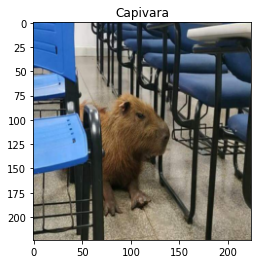

In [10]:
img, labels = next(iter(test_data))
plot_img(img, (classes[labels])[4:], std, mean)

# Definição do modelo

Decidimos utilizar da técnica de transfer learning


*   Modelo pré-treinado: resnet18
*   O gradiente foi desabilitado em todas as layers (só precisamos do gradiente nas Fully connected layers)



In [11]:
model = models.resnext101_32x8d(pretrained = True)
'''for param in model.parameters():
    param.requires_grad = False'''
model

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

Treinando na gpu ou cpu?

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

Definição das FCL


*   TODO
*   O modelo é enviado para a gpu (caso tenha cuda)



In [13]:
model.fc = nn.Sequential(
    nn.Linear(in_features=model.fc.in_features, out_features=10, bias=True)
    )
    
model = model.to(device)



*   TODO
*   Otimizador escolhido é o AdamW com learning rate padrão (1e-3)



In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.fc.parameters())

# Treinamento

Definição da função de treino


*   A função define somente uma época
*   retorna as losses e a acurácia obtida na validação



In [15]:
def train(model, train_data, eval_data):
    
    # Train steps
    
    train_loss = 0
    eval_loss = 0
    acc = 0

    model.train()
    for images, labels in train_data:

        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        loss = criterion(output, labels)

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        train_loss += loss
    
    train_loss /= len(train_data)

    # Validation steps
    
    n_prev = 0
    correct = 0
    
    model.eval()
    with torch.no_grad():
        for v_images, v_labels in eval_data:

            v_images = v_images.to(device)
            v_labels = v_labels.to(device)

            v_output = model(v_images)
            eval_loss += criterion(v_output, v_labels)

            _,prev = torch.max(v_output, dim = 1)
            n_prev += 1

            if prev == v_labels:
                correct += 1
        
        eval_loss /= len(eval_data)
        
        acc = correct/n_prev*100
    
    return train_loss, eval_loss, acc

Etapa de treinamento


*   O número de épocas é definida na variavel epochs
*   ao fim de cada época é imprimido na tela as losses e a acurácia obtida

In [16]:
epochs = 10

list_train_loss = []
list_eval_loss = []
list_acc = []

for epoch in range(1, epochs+1):
    train_loss, eval_loss, acc = train(model, train_data, eval_data)
    list_train_loss.append(train_loss)
    list_eval_loss.append(eval_loss)
    list_acc.append(round(acc, 2))

    if epoch != 1 and list_acc[-1] > max(list_acc):
        torch.save(model.state_dict(), 'trainedModel/model.pt')
    
    print(f'Epoch: {epoch} loss: {train_loss.item():.4f} validation loss: {eval_loss.item():.4f} Accuracy: {acc:.2f}')	

Epoch: 1 loss: 0.9779 validation loss: 0.2709 Accuracy: 96.67
Epoch: 2 loss: 0.2083 validation loss: 0.1357 Accuracy: 98.15
Epoch: 3 loss: 0.1345 validation loss: 0.0945 Accuracy: 98.89
Epoch: 4 loss: 0.0994 validation loss: 0.0757 Accuracy: 97.78
Epoch: 5 loss: 0.0649 validation loss: 0.0610 Accuracy: 98.89
Epoch: 6 loss: 0.0639 validation loss: 0.0535 Accuracy: 98.89
Epoch: 7 loss: 0.0369 validation loss: 0.0501 Accuracy: 99.26
Epoch: 8 loss: 0.0347 validation loss: 0.0503 Accuracy: 98.89
Epoch: 9 loss: 0.0348 validation loss: 0.0427 Accuracy: 99.26
Epoch: 10 loss: 0.0314 validation loss: 0.0476 Accuracy: 98.89


Mostra os gráficos do treinamento

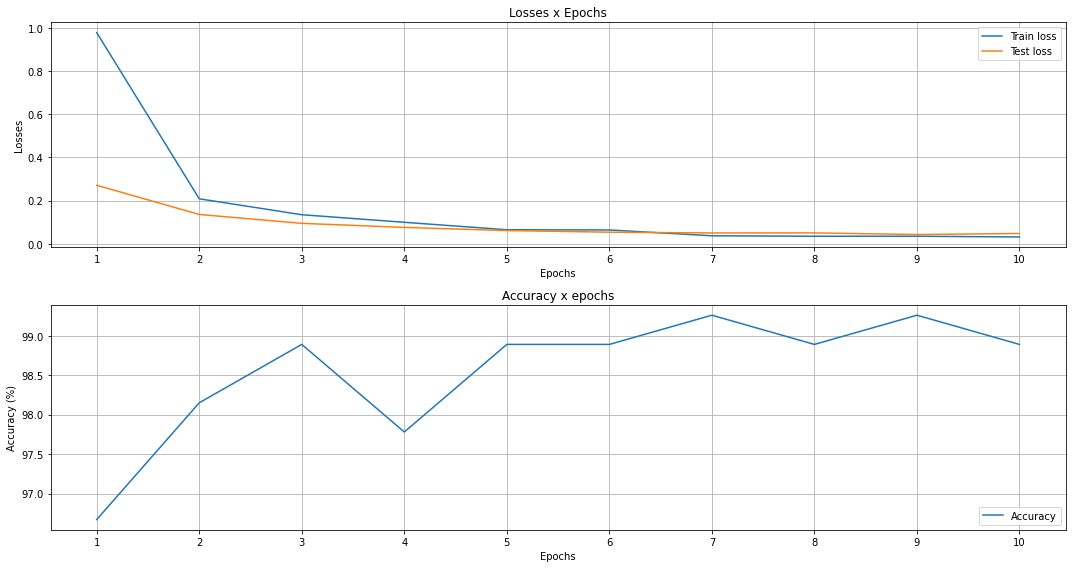

In [18]:
plot_train_graph(list_train_loss, list_eval_loss, list_acc, epochs)
model.load_state_dict(torch.load('trainedModel/model.pt'))

Etapa de teste


*   envia o dataset de treino para uma rede já treinada
*   recebe a acurácia do teste



In [19]:
wrong_img = []
def test(model, test_data):
    n_prev = 0
    correct = 0
    
    model.eval()
    with torch.no_grad():
        for t_images, t_labels in test_data:
        
            t_images = t_images.to(device)
            t_labels = t_labels.to(device)

            t_output = model(t_images)

            value,prev = torch.max(nn.functional.softmax(t_output, dim=1), dim = 1)
            n_prev += 1

            if prev == t_labels:
                correct += 1
            else:
                wrong_img.append((t_images, prev, t_labels, value*100))
    
    return correct/n_prev*100

Imprime a acurácia obtida

In [20]:
test_acc = test(model, test_data)
print(f'Accuracy: {test_acc:.2f}')

Accuracy: 98.15


In [21]:
def predict(img, model):
    test_out = 0
    value = 0
    prev = 0
    class_ = ''
    
    img.cpu()
    model.cpu()

    with torch.no_grad():
        test_out = model(img)
        value,prev = torch.max(torch.nn.functional.softmax(test_out, dim=1), dim = 1)

    value *= 100

    if value > 60:
        if prev < 5:
            class_ = 'a'
        else:
            class_ = 'b'
    else:
        prev = 10
        class_ = 'c'

    return prev, class_

Prediction: Lobo guara
Class: a


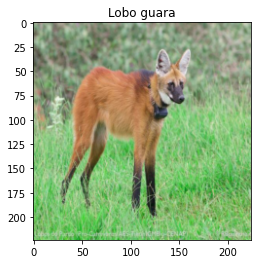

Prediction: Tatu canastra percentage: 71%


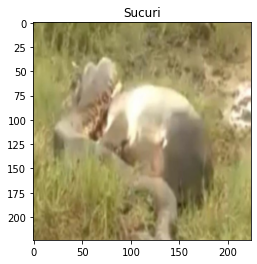

Prediction: Ariranha percentage: 88%


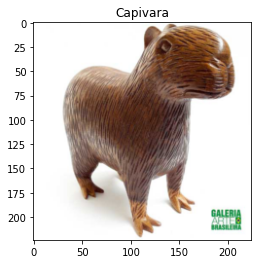

Prediction: Ariranha percentage: 51%


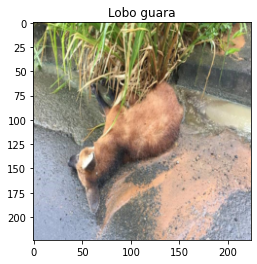

Prediction: Lobo guara percentage: 32%


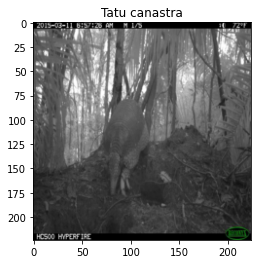

Prediction: Lobo guara percentage: 56%


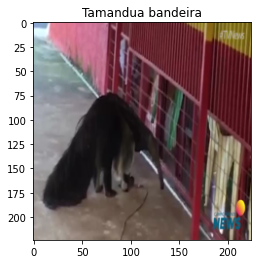

In [22]:
img, label = next(iter(test_data))

prev, class_ = predict(img, model)

print(f'Prediction: {(classes[prev])[4:]}\nClass: {class_}')
plot_img(img, (classes[label])[4:], std, mean)

for img, pred, label, value in wrong_img:
    print(f'Prediction: {(classes[pred])[4:]} percentage: {ceil(value)}%')
    plot_img(img, (classes[label])[4:], std, mean)